# Выявление абонентов с двумя сим-картами в сети МФ

## Задача.
Определить абонентов (msisdn), которые являются одной и той же Персоной (человеком)/
Нужно построить классификацию, определяющую является ли пара msisdn принадлижайшей одной Персоне.

## Метрика.
Для оценки качества используется метрика $F1$, так как классы несбалансированы.
$$F1 = 2\frac{Precission * Recall}{Precission + Recall}$$

## План.
* Определение целевого события
* Описание идеи алгоритма
* Анализ данных
* Формирование фичей
* Построение моделей
* Предсказание

In [1]:
!pip install ipynb
import pandas as pd
import os
from os import walk
import datetime
pd.set_option('display.max_columns', 500)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date

import csv

import folium
from folium import plugins
from folium.plugins import HeatMap
import branca
import branca.colormap as cm

from ipynb.fs.full.persona_msisdn_functions import *

## Определение целевого события

Рассматриваем неупорядоченные пары номеров телефонов (пары без повторений и не важен порядок, в котором указаны телефоны).

Если пара номеров принадлежит одной Персоне, то целевое событие равно 1, если разным Персонам, то 0.

В файле 02_Факты для некоторых пар указано, что они принадлежат одной Персоне.

### Генерируем дополнительные пары, которые не принадлежат одной Персоне.
Считаем, что вероятность того, что у Персоны 3 и более телефонов небольшая и этим событием можно принебречь. Тогда любая пара телефонов, у которой первый msisdn из файла 02_Факты, а второй msisdn не совподает с указанным номером-парой для первого телефона, не принадлежит одной Персоне.

Пара номеров телефонов не принадлежит одной Персоне с вероятьностью более $1 - \frac{2}{n-1}$. Добавдяем в выборку для построения моделей пары номеров, у которых каждый номер не принадлежит файлу 02_Факты.

## Идея алгоритма

Один из способов понять, принадлежат ли телефоны одной Персоне, это изучение движения номеров.
Для номеров одной персоны движения должны быть "похожими".

Так как пложение абонентов регистрируется в случайные моменты времени, у нас нет достоверной информации где находится абонент в каждый момент времени, поэтому рассчитать точное расстояние между телефонами невозможно.

Чтобы оценить расстояние между телефонами мы приблизительно определяем положение абноента в нужные для нас моменты времени.

## Анализ данных

In [2]:
# загружаем данные
current_directory = r'C:\Users\ekaterina.adischeva\Documents\Scripts\BD_task\Техническое задание_аналитик больших данных\Данные'
current_directory = current_directory.replace('\\','/')
os.chdir(current_directory)

df_data = pd.read_csv('02_Data.csv', sep = ';', dtype = {'imei': str, 'lac' : 'str', 'cid' : 'str'})
facts = pd.read_excel('01_Факты.xlsx', header = None)
tac_dict = pd.read_csv('03_устройства.csv', quoting=csv.QUOTE_NONE)
event_type = pd.read_excel('04_event_type.xlsx')

2 абонента из пар не попали в выборку с детальными данными. Ничего с этим не делаем.

In [3]:
# for 2 persons we don't have second msisdn in our dataset
display(facts[~facts[1].isin(df_data['msisdn'])], 
        facts[~facts[0].isin(df_data['msisdn'])])

,0,1
1,158510912201,158528852857
17,158528850493,158530004641


,0,1


In [4]:
# Оцениваем пустые данные в датафрейм. Отсутсвуют данные по imei и моделям телефона.
df_data.shape[0] - df_data.count()

lac                0
cid                0
msisdn             0
imei           11588
event_type         0
tstamp             0
long               0
lat                0
max_dist           0
cell_type          0
start_angle        0
end_angle          0
dtype: int64

In [5]:
# заполняю пустые значения imei самым популярным значением для абонента
msisdn_imei_count = df_data[~df_data['imei'].isna()].groupby(['msisdn', 'imei'])['lac'].count().reset_index().sort_values('lac', ascending = False)
msisdn_imei_count['K'] = msisdn_imei_count.groupby('msisdn')['imei'].cumcount()
msisdn_imei_count = msisdn_imei_count[msisdn_imei_count['K'] == 0][['msisdn', 'imei']].rename(columns = {'imei':'imei_pop'})
print(df_data['msisdn'].nunique(), msisdn_imei_count.shape[0])
df_data = df_data.merge(msisdn_imei_count, on = ['msisdn'], how = 'left')
df_data['imei'] = df_data['imei'].fillna(df_data['imei_pop'])
df_data.drop(columns = ['imei_pop'], inplace = True)
df_data.shape[0] - df_data.count()

2361 2359


lac            0
cid            0
msisdn         0
imei           5
event_type     0
tstamp         0
long           0
lat            0
max_dist       0
cell_type      0
start_angle    0
end_angle      0
dtype: int64

In [6]:
# Преобразовываем данные в удобный формат
tac_dict.columns = tac_dict.columns.str.replace('\"','')
for column_name in tac_dict.columns:
    tac_dict[column_name] = tac_dict[column_name].str.replace('\"','')

# Конвертирую время
df_data['datetime'] = pd.to_timedelta(df_data['tstamp']/1000, unit='S') + pd.Timestamp('1970-1-1')
df_data['datetime'] = pd.to_datetime(df_data['datetime'])

In [7]:
# Объединяем данные в один датафрейм
df_data = df_data.merge(event_type, left_on = ['event_type'], right_on = 'Номер', how = 'left')

## Анализ параметров, связанных с моделью телефона
Строим массив *msisdn_device*, в котором для каждого абонента указываем инфомрацию о модели телефона
* кол-во используемых аппаратов
* imei самого популярного аппарата
* Платформа
* Индикатор, что Платформа попадает в TOP 5
* Производитель
* Индикатор, что Производитель попадает в TOP 10
* Тип устройства

In [8]:
msisdn_imei_qnt = df_data.groupby(['msisdn'])['imei'].nunique().reset_index()
msisdn_imei_qnt.set_index('msisdn', inplace = True)
msisdn_imei_count.set_index('msisdn', inplace = True)
msisdn_device = pd.concat([msisdn_imei_qnt, msisdn_imei_count], axis = 1).reset_index()

msisdn_device['tac'] = msisdn_device['imei_pop'].str.slice(0,8)
msisdn_device = msisdn_device.merge(tac_dict, on = ['tac'], how = 'left')

In [9]:
top_vendors_list = msisdn_device['vendor'].value_counts().head(10).index
top_platforms_list = msisdn_device['platform'].value_counts().head(5).index

In [10]:
msisdn_device['top_vendor'] = np.where(msisdn_device['vendor'].isin(top_vendors_list), msisdn_device['vendor'], 'Other')
msisdn_device['top_platform'] = np.where(msisdn_device['platform'].isin(top_platforms_list), msisdn_device['platform'], 'Other')
msisdn_device['type'].fillna('Other', inplace = True)
msisdn_device.drop(columns = 'tac', inplace = True)

## Анализ времени

Смотрим распределение событий по времени, чтобы убрать данные, коотрые попали в таблицу по ошибке. Убираем события, произошедшие после 26 мая 2013.
События 22 мая оставляем, так как их распределние по времени похоже на распредления в другие дни. 

C:\Users\ekaterina.adischeva\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


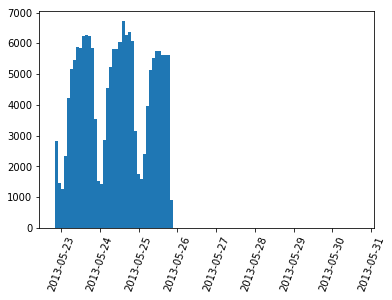

In [11]:
plt.hist(df_data['datetime'].values, bins=100)
plt.xticks(rotation=70)
plt.show()

In [12]:
df_data.loc[:, 'date'] = df_data['datetime'].dt.date
print(df_data['date'].value_counts())
df_data = df_data[(df_data['datetime']  < datetime.strptime('2013-05-26', '%Y-%m-%d'))
         #         & (df_data['datetime']  >= datetime.strptime('2013-05-23', '%Y-%m-%d'))
                 ]

2013-05-24    61642
2013-05-23    59463
2013-05-25    48519
2013-05-22     4450
2013-05-29       24
2013-05-28       18
2013-05-30        7
Name: date, dtype: int64


## Анализ координат
Проверяем расположение и параметры базовых станций

In [13]:
CENTER_LAT, CENTER_LONG = 55.7522200, 37.6155600
m = folium.Map(location=(CENTER_LAT, CENTER_LONG))
show_circles_on_map(m, df_data.sample(500), "lat", "long", "blue")

Смотрим распределение базовых станций по углам действия

C:\Users\ekaterina.adischeva\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


60.0     156940
47.0       9719
90.0       3104
360.0      2176
65.0       2135
Name: angle, dtype: int64

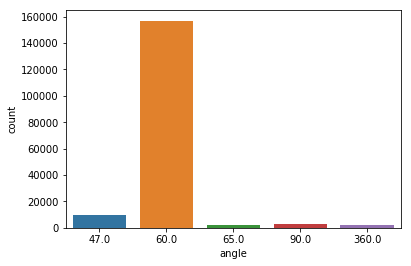

In [14]:
df_data['angle'] = np.where(df_data['end_angle'] < df_data['start_angle'], df_data['end_angle'] - df_data['start_angle'] + 360,
                        df_data['end_angle'] - df_data['start_angle'])
sns.countplot(df_data['angle'])
df_data['angle'].value_counts()

Смотрим распределение радиусов действия БС

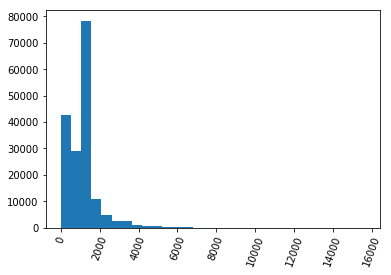

count    174074.000000
mean       1101.883917
std         849.705447
min           1.000000
25%         532.000000
50%        1104.000000
75%        1251.000000
max       15661.000000
Name: max_dist, dtype: float64

In [15]:
plt.hist(df_data['max_dist'].values, bins=30)
plt.xticks(rotation=70)
plt.show()
df_data['max_dist'].describe()

# Преобразование координат для создания параметров по координатам

Для событий определяю координаты прямоугольника, в котором действует БС, и где событие могло произойти.

In [16]:
df_data_copy = df_data.copy()
df_data = BS_rectangle_coordinate(df_data_copy, CENTER_LAT, CENTER_LONG)

Теперь строим две таблицы с информацией о расположение абноента в определнные временные срезы.
В первой таблице для каждого отрезка времени мы определяем расположение как среднее по всем событиям этого отрезка.
Если событий в этом отрезке не было, то оцениваем координаты как линейную комбинацию ближайших окружающих точек. Тут для каждого интервала определяется координаты.

Во второй таблице мы оцениваем расположение только по событиям, которые произошли в ограниченном инервале времени. То есть на координаты влияют только ближайшие события. Если в зааднном интервале времени событий не произошло, то мы не можем определить координаты.

# Создание таблицы `ln`

In [17]:
# разбиваем время на BINS_QNT равных интервалов
BINS_QNT_LN = 150
df_data_bin_ln, bins_list_ln = CreateTimeBeans(df_data, BINS_QNT_LN)

# создаем декартовое произведение абонентов и интервалов. Затем эту таблицу мы дополним подобранными координатами
df_data_pivot_base_ln = CreatePivotBase(df_data_bin_ln)

# агрегируем зарегистрированные события по интервалам времени.
# Для интервалов с событиями определяем среднее расположения квадрата действия БС
df_data_bin_agg_ln = AggData(df_data_bin_ln)

# линейно апроксиммируем координаты в интервалах, в которых не было событий
df_data_agg_for_pivot_ln = LinearCombData(df_data_pivot_base_ln, df_data_bin_agg_ln)

# таблица с инфомрацией об одном абоненте
df_data_agg_pivot_ln = CreatePivot(df_data_agg_for_pivot_ln)

# Создание таблицы `shift`

In [18]:
BINS_QNT_SHIFT = 75

# таблицу дополняем N сдвигами на DELTA минут
DELTA, N = 30, 2
df_data_shift = AddDataDelta(df_data, DELTA, N)

# разбиваем время на BINS_QNT равных интервалов
df_data_bin_shift, bins_list_shift = CreateTimeBeans(df_data_shift, BINS_QNT_SHIFT)

# создаем декартовое произведение абонентов и интервалов. Затем эту таблицу мы дополним подобранными координатами
df_data_pivot_base_shift = CreatePivotBase(df_data_bin_shift)

# агрегируем зарегистрированные события по интервалам времени.
# Для интервалов с событиями определяем среднее расположения квадрата действия БС
df_data_bin_agg_shift = AggData(df_data_bin_shift)

# Дополняем подобранные координаты к декартовому произведению абонентов и интервалов
df_data_agg_for_pivot_shift = CombData(df_data_pivot_base_shift, df_data_bin_agg_shift)

df_data_agg_pivot_shift = CreatePivot(df_data_agg_for_pivot_shift)

Создаем таблицу со списком пар абонентов, на которой мы будем проводить обучение

In [19]:
# В таблицу попадают все пары из таблицы Факты, PAIR_RANDOM_SHARE пар, у которых только один номер из таблицу Факты
# RANDOM_RANDOM_SHARE пар, у которых только один номер из таблицы Факты

PAIR_RANDOM_SHARE = 0.25
RANDOM_RANDOM_SHARE = 0.025

df_msisdn_pairs = CreateMsisdnPairs(facts, df_data, PAIR_RANDOM_SHARE, RANDOM_RANDOM_SHARE)

Sample pairs: 122
Pair Random pairs: 128790
Index(['msisdn_x', 'msisdn_y'], dtype='object')
Random Random pairs: 56154
(185066, 3)


ipynb.fs.full.persona_msisdn_functions:302: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\ekaterina.adischeva\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [20]:
dist_ind_ln, coord_ind_ln, center_dist_ind_ln = True, False, False
dist_ind_shift, coord_ind_shift, center_dist_ind_shift = False, False, False
df_X_ln = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_ln, bins_list_ln, 'ln', dist_ind_ln, coord_ind_ln, center_dist_ind_ln, CENTER_LAT, CENTER_LONG)
df_X_shift = CreateAndProcessPivot(df_msisdn_pairs, df_data_agg_pivot_shift, bins_list_shift, 'shift', dist_ind_shift, coord_ind_shift, center_dist_ind_shift, CENTER_LAT, CENTER_LONG)

(182880, 148)
(182880, 5)


In [21]:
df_X_devices = ProcessPhoneFeaturesPivot(msisdn_device, df_msisdn_pairs, df_data)

In [22]:
df_X = pd.concat([df_X_shift, df_X_ln], axis = 1)
df_X.reset_index(inplace = True)
df_X_devices.reset_index(inplace = True)
df_X_devices.drop(columns = ['is_pair'], inplace = True)
df_X_devices['n'] = df_X_devices.groupby(['msisdn_x', 'msisdn_y'])['imei_y'].cumcount()
df_X_devices = df_X_devices[df_X_devices['n'] == 0].drop(columns = ['n'])

In [23]:
print(df_X.shape)
df_X = df_X.merge(df_X_devices, on = ['msisdn_x', 'msisdn_y'])
print(df_X.shape)

(182880, 156)
(182880, 165)


In [ ]:
for feature in ['type_x', 'top_vendor_x', 'top_platform_x', 'type_y', 'top_vendor_y', 'top_platform_y']:
    for feature_value in df_X[feature].unique():
        column_name = feature + '_' + feature_value
        df_X[column_name] = (df_X[feature] == feature_value) * 1
    df_X.drop(columns = [feature], inplace = True)

In [ ]:
X = df_X.drop(columns = ['msisdn_x', 'msisdn_y', 'is_pair']).fillna(0)
y = df_X['is_pair']

In [ ]:
df_X.head()

,is_pair,msisdn_x,msisdn_y,dist_mean_shift,intersect_mean_shift,intersect_count_shift,center_dist_x_mean_shift,center_dist_y_mean_shift,7_dist_ln,8_dist_ln,9_dist_ln,10_dist_ln,11_dist_ln,12_dist_ln,13_dist_ln,14_dist_ln,15_dist_ln,16_dist_ln,17_dist_ln,18_dist_ln,19_dist_ln,20_dist_ln,21_dist_ln,22_dist_ln,23_dist_ln,24_dist_ln,25_dist_ln,26_dist_ln,27_dist_ln,28_dist_ln,29_dist_ln,30_dist_ln,31_dist_ln,32_dist_ln,33_dist_ln,34_dist_ln,35_dist_ln,36_dist_ln,37_dist_ln,38_dist_ln,39_dist_ln,40_dist_ln,41_dist_ln,42_dist_ln,43_dist_ln,44_dist_ln,45_dist_ln,46_dist_ln,47_dist_ln,48_dist_ln,49_dist_ln,50_dist_ln,51_dist_ln,52_dist_ln,53_dist_ln,54_dist_ln,55_dist_ln,56_dist_ln,57_dist_ln,58_dist_ln,59_dist_ln,60_dist_ln,61_dist_ln,62_dist_ln,63_dist_ln,64_dist_ln,65_dist_ln,66_dist_ln,67_dist_ln,68_dist_ln,69_dist_ln,70_dist_ln,71_dist_ln,72_dist_ln,73_dist_ln,74_dist_ln,75_dist_ln,76_dist_ln,77_dist_ln,78_dist_ln,79_dist_ln,80_dist_ln,81_dist_ln,82_dist_ln,83_dist_ln,84_dist_ln,85_dist_ln,86_dist_ln,87_dist_ln,88_dist_ln,89_dist_ln,90_dist_ln,91_dist_ln,92_dist_ln,93_dist_ln,94_dist_ln,95_dist_ln,96_dist_ln,97_dist_ln,98_dist_ln,99_dist_ln,100_dist_ln,101_dist_ln,102_dist_ln,103_dist_ln,104_dist_ln,105_dist_ln,106_dist_ln,107_dist_ln,108_dist_ln,109_dist_ln,110_dist_ln,111_dist_ln,112_dist_ln,113_dist_ln,114_dist_ln,115_dist_ln,116_dist_ln,117_dist_ln,118_dist_ln,119_dist_ln,120_dist_ln,121_dist_ln,122_dist_ln,123_dist_ln,124_dist_ln,125_dist_ln,126_dist_ln,127_dist_ln,128_dist_ln,129_dist_ln,130_dist_ln,131_dist_ln,132_dist_ln,133_dist_ln,134_dist_ln,135_dist_ln,136_dist_ln,137_dist_ln,138_dist_ln,139_dist_ln,140_dist_ln,141_dist_ln,142_dist_ln,143_dist_ln,144_dist_ln,145_dist_ln,146_dist_ln,147_dist_ln,148_dist_ln,149_dist_ln,dist_mean_ln,intersect_mean_ln,intersect_count_ln,center_dist_x_mean_ln,center_dist_y_mean_ln,imei_x,imei_y,same_imei,type_x_Phone,type_x_SmartPhone,type_x_Other,type_x_Laptop,type_x_USB modem,type_x_Network device,type_x_Data card,top_vendor_x_Nokia,top_vendor_x_Other,top_vendor_x_HTC,top_vendor_x_Samsung,top_vendor_x_Philips,top_vendor_x_Apple,top_vendor_x_Huawei,top_vendor_x_Sony Ericsson,top_vendor_x_LG,top_vendor_x_Fly,top_vendor_x_Sony,top_platform_x_ISA,top_platform_x_Proprietary,top_platform_x_Other,top_platform_x_Android,top_platform_x_iOS,top_platform_x_Symbian OS,type_y_Laptop,type_y_Phone,type_y_SmartPhone,type_y_USB modem,type_y_Other,type_y_Data card,type_y_Network device,top_vendor_y_Apple,top_vendor_y_Nokia,top_vendor_y_Samsung,top_vendor_y_Huawei,top_vendor_y_Sony Ericsson,top_vendor_y_Other,top_vendor_y_Philips,top_vendor_y_HTC,top_vendor_y_LG,top_vendor_y_Fly,top_vendor_y_Sony,top_platform_y_iOS,top_platform_y_Proprietary,top_platform_y_ISA,top_platform_y_Symbian OS,top_platform_y_Android,top_platform_y_Other
0,0,158533820373,158530567031,48.197446,0.0,0.013889,45.419788,3.212076,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.782625,45.877081,45.971724,46.066552,46.161565,46.256760,46.352138,46.447697,46.543435,46.639352,46.735446,46.831717,46.928164,47.024785,47.121579,47.218545,47.315682,47.412989,47.510466,47.608110,47.705921,47.803898,47.902040,48.000346,48.098815,48.197446,48.210754,48.224065,48.237377,48.250690,48.264006,48.277324,48.290643,48.303964,48.317287,48.330612,48.343938,48.357267,48.370597,48.383929,48.39726

## Построение модели

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
categorical_features = ['type_x', 'top_vendor_x', 'top_platform_x', 'type_y', 'top_vendor_y', 'top_platform_y']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc = RandomForestClassifier(random_state=42)

pipe = Pipeline(steps=[#('preprocessor', preprocessor),
                       ('classifier', RandomForestClassifier(random_state=42))])

search = GridSearchCV(rfc, param_grid=param_grid, scoring = 'f1', cv = 5)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
search.get_params().keys()